# Data Preprocessing

_Deep Learning Nanodegree Program | Capstone Project_

---


##  Related data sets

We will be using the [kkbox dataset](https://www.kaggle.com/bvmadduluri/wsdm-kkbox) which has been used for the [WSDM - KKBox's Music Recommendation Challenge](https://www.kaggle.com/c/kkbox-music-recommendation-challenge/data) kaggle competetion.


## Downloading the data

To download the dataset, one has to first download kaggle API token as follows:

- 1.cd ~/.kaggle
- 2.homepage www.kaggle.com -> Your Account -> Create New API token
- 3.mv ~/Downloads/kaggle.json ./
- 4.chmod 600 ./kaggle.json

In [ ]:
# install kaggle SDK
!pip install kaggle

# download and decompress data
!mkdir ./data
!kaggle competitions download -c kkbox-music-recommendation-challenge -p ./data

!unzip ./data/kkbox-music-recommendation-challenge.zip  -d ./data
!7z e  ./data/members.csv.7z -o./data/
!7z e  ./data/sample_submission.csv.7z -o./data/
!7z e  ./data/test.csv.7z -o./data/
!7z e  ./data/train.csv.7z -o./data/
!7z e  ./data/song_extra_info.csv.7z -o./data/
!7z e  ./data/songs.csv.7z -o./data/

# clean up
!rm ./data/kkbox-music-recommendation-challenge.zip
!rm ./data/*.7z
!rm ./p7zip-16.02-10.el7.x86_64.rpm
!rm ./p7zip-plugins-16.02-10.el7.x86_64.rpm

In [1]:
# Make sure that we use SageMaker 1.x
!pip install sagemaker==1.72.0

     |████████████████████████████████| 297 kB 15.7 MB/s eta 0:00:01
  Created wheel for sagemaker: filename=sagemaker-1.72.0-py2.py3-none-any.whl size=386358 sha256=c47bc5392f1844a496857acf174acaa461b3e23c5e88a9f0e278ee695b78ca1a
  Stored in directory: /home/ec2-user/.cache/pip/wheels/c3/58/70/85faf4437568bfaa4c419937569ba1fe54d44c5db42406bbd7
Successfully built sagemaker
  Attempting uninstall: smdebug-rulesconfig
    Found existing installation: smdebug-rulesconfig 1.0.1
    Uninstalling smdebug-rulesconfig-1.0.1:
      Successfully uninstalled smdebug-rulesconfig-1.0.1
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.24.1
    Uninstalling sagemaker-2.24.1:
      Successfully uninstalled sagemaker-2.24.1
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


## Step 2: Preparing and Processing the data

To begin with, we will read in each of the reviews and combine them into a single input structure. Then, we will split the dataset into a training set and a testing set.

### 2.1 Song data

In [2]:
import pandas as pd

songs = pd.read_csv('./data/songs.csv')
song_extra_info = pd.read_csv('./data/song_extra_info.csv')


In [3]:
songs_all = pd.concat([songs.set_index('song_id'), song_extra_info.set_index('song_id')],axis=1)
del songs, song_extra_info

In [4]:
songs_all.head(3)

,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc
CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640.0,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0,焚情,TWB531410010
o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328.0,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0,PLAYING WITH FIRE,NaN
DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781.0,465,SUPER JUNIOR,NaN,NaN,31.0,SORRY| SORRY,NaN


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


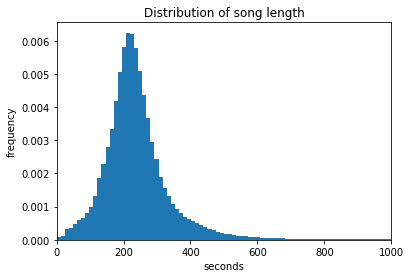

In [5]:
import matplotlib.pyplot as plt
plt.hist(songs_all['song_length']/1000, bins=1000, density=True)
plt.xlim(0,1000)
plt.xlabel('seconds')
plt.ylabel('frequency')
plt.title('Distribution of song length')
plt.show()

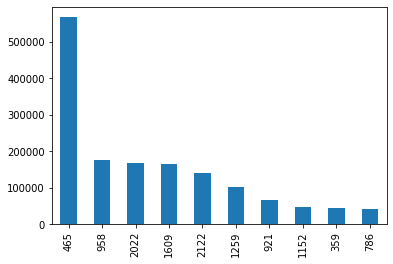

In [6]:
import matplotlib.pyplot as plt
songs_all['genre_ids'].value_counts()[:10].plot.bar()
plt.show()

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 35388 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 32882 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 38899 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 27138 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 22294 missing from current font.
  font.set_text(s, 0.0, fla

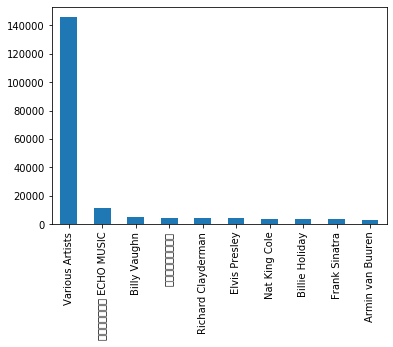

In [7]:
import matplotlib.pyplot as plt
songs_all['artist_name'].value_counts()[:10].plot.bar()
plt.show()

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 26519 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 22805 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 26446 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 23721 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 20462 missing from current font.
  font.set_text(s, 0.0, fla

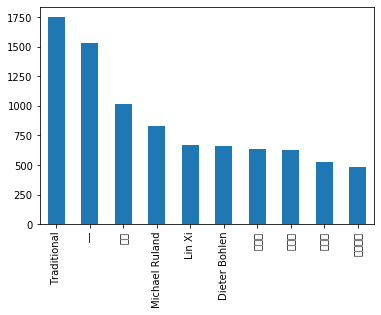

In [8]:
import matplotlib.pyplot as plt
songs_all['lyricist'].value_counts()[:10].plot.bar()
plt.show()

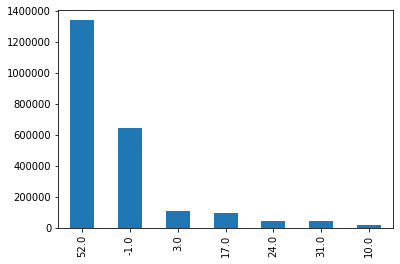

In [9]:
import matplotlib.pyplot as plt
songs_all['language'].value_counts()[:10].plot.bar()
plt.show()

In [3]:
from code.utils import *

In [4]:
songs_all['year']=songs_all['isrc'].apply(isrc_to_year)
songs_all['country']=songs_all['isrc'].apply(isrc_to_country)

In [5]:
songs_all['song_length'].fillna(pd.to_numeric(songs_all['song_length']).mean(),inplace=True)
songs_all['year'].fillna(pd.to_numeric(songs_all['year']).mean(),inplace=True)

In [6]:
def get_mapping(raw_value_list, with_nan = True):
    value_list = [value.split('|') for value in raw_value_list if type(value)==str]
    value_set = list(set([el for values in value_list for el in values]))
    if with_nan:
        dict_value_to_idx =  dict(zip([np.NaN]+value_set,range(1+len(value_set))))
    else:
        dict_value_to_idx =  dict(zip(value_set,range(len(value_set))))
        
    return dict_value_to_idx

def list_to_idx(my_list, mapping):
    #embed = np.zeros((len(mapping),1))
    if type(my_list)==str:
        my_list = my_list.split('|')
    else:
        my_list = [my_list]
    
    idx_list = list(map(mapping.get, my_list))[0]
    
    return idx_list

def tokenize(raw_value_list, with_nan=True):
    from functools import partial
    dict_value_to_idx = get_mapping(raw_value_list, with_nan)
    func = partial(list_to_idx, mapping = dict_value_to_idx)
    idx_list = list(map(func, raw_value_list))
    
    return idx_list, dict_value_to_idx
    

In [7]:
token_to_idx = dict()

In [8]:
songs_all['genre'],token_to_idx['genre'] = tokenize(songs_all['genre_ids'])

In [9]:
songs_all['artist'],token_to_idx['artist']  = tokenize(songs_all['artist_name'])

In [10]:
songs_all['composer'],token_to_idx['composer'] = tokenize(songs_all['composer'])

In [11]:
songs_all['lyricist'],token_to_idx['lyricist'] = tokenize(songs_all['lyricist'])

In [12]:
songs_all['country'],token_to_idx['country'] = tokenize(songs_all['country'])

In [13]:
songs_all['language'],token_to_idx['language'] = tokenize(songs_all['language'].map(str))

In [14]:
songs_all.drop(columns=['genre_ids','isrc','artist_name','name'],inplace=True)

In [15]:
songs_all = songs_all.astype(int)

In [16]:
for col in songs_all.columns:
    print(col, len(songs_all[col].unique()),songs_all[col].min(), songs_all[col].max())

song_length 146535 185 12173850
composer 212453 0 360932
lyricist 79512 0 128373
language 11 1 11
year 100 1918 2017
country 201 0 200
genre 183 0 191
artist 211388 0 239749


In [17]:
songs_all = songs_all.reset_index().rename(columns={'index':'song_id'})

In [18]:
token_to_idx['song_id'] = dict(zip(set(songs_all['song_id']),range(len(set(songs_all['song_id'])))))

In [19]:
songs_all['song_id']=songs_all['song_id'].map(token_to_idx['song_id'])

In [20]:
songs_all

,song_id,song_length,composer,lyricist,language,year,country,genre,artist
0,164982,247640,241079,103323,1,2014,124,89,127989
1,122889,197328,111072,29717,7,2006,0,36,10648
2,1049636,231781,0,0,7,2006,0,89,41391
3,884126,273554,123359,827,1,2002,124,89,38660
4,1725233,140329,14329,20425,5,2006,0,135,145547
...,...,...,...,...,...,...,...,...,...
2296864,1966997,246993,0,0,11,2010,161,0,0
2296865,439700,246993,0,0,11,2014,200,0,0
2296866,70928,246993,0,0,11,2015,161,0,0
2296867,1659828,246993,0,0,11,2012,153,0,0


### 2.2 member data

In [10]:
members = pd.read_csv('./data/members.csv')

In [11]:
#members.set_index('msno',inplace=True)

In [ ]:
members['city'],token_to_idx['city'] = tokenize(members['city'].map(str))

In [ ]:
members['gender'],token_to_idx['gender'] = tokenize(members['gender'].map(str))

In [ ]:
members['registered_via'],token_to_idx['registered_via'] = tokenize(members['registered_via'].map(str))

In [26]:
members['app_age'] = pd.to_datetime(members['expiration_date'],format='%Y%m%d')- pd.to_datetime(members['registration_init_time'],format='%Y%m%d')

In [27]:
members['app_age'] = members['app_age'].map(lambda x:x.days if x.days>=0 else 0)

In [28]:
members['registration'] = pd.to_datetime(members['registration_init_time'],format='%Y%m%d')- pd.to_datetime(members['registration_init_time'],format='%Y%m%d').min()

In [29]:
members['registration'] = members['registration'].map(lambda x:x.days)

In [30]:
members.drop(columns = ['bd','registration_init_time','expiration_date'],inplace=True)

In [31]:
for col in members.columns:
    print(col, len(members[col].unique()),members[col].min(), members[col].max())
    #plt.hist(members[col])
    #plt.show()

msno 34403 ++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= zzzRi5ek1YCKTGns8C77xwAutE05PAPmz8T/pIIQhzE=
city 21 1 21
gender 3 1 3
registered_via 6 1 6
app_age 4345 0 5149
registration 3862 0 4722


In [32]:
token_to_idx['msno'] = dict(zip(set(members['msno']),range(len(set(members['msno'])))))


In [33]:
members['msno']=members['msno'].map(token_to_idx['msno'])

In [15]:
members

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613
...,...,...,...,...,...,...,...
34398,Wwd/cudKVuLJ3txRVxlg2Zaeliu+LRUfiBmfrnxhRCY=,1,0,NaN,7,20131111,20170910
34399,g3JGnJX6Hg50lFbrNWfsHwCUmApIkiv2M8sXOaeXoIQ=,4,18,male,3,20141024,20170518
34400,IMaPMJuyN+ip9Vqi+z2XuXbFAP2kbHr+EvvCNkFfj+o=,1,0,NaN,7,20130802,20170908
34401,WAnCAJjUty9Stv8yKtV7ZC7PN+ilOy5FX3aIJgGPANM=,1,0,NaN,7,20151020,20170920


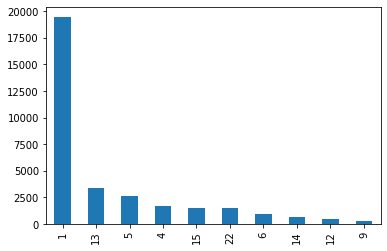

In [16]:
import matplotlib.pyplot as plt
members['city'].value_counts()[:10].plot.bar()
plt.show()

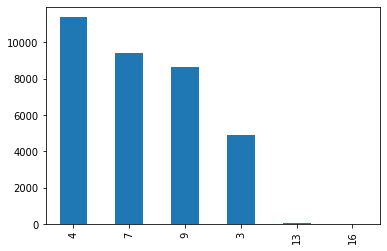

In [17]:
import matplotlib.pyplot as plt
members['registered_via'].value_counts()[:10].plot.bar()
plt.show()

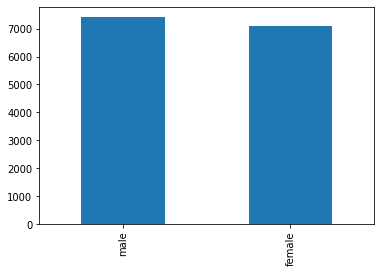

In [18]:
import matplotlib.pyplot as plt
members['gender'].value_counts()[:10].plot.bar()
plt.show()

In [35]:
data = pd.read_csv('./data/train.csv')

In [36]:
data['source_system_tab'], token_to_idx['source_system_tab'] = tokenize(data['source_system_tab'])

In [37]:
data['source_screen_name'], token_to_idx['source_screen_name'] = tokenize(data['source_screen_name'])

In [38]:
data['source_type'], token_to_idx['source_type'] = tokenize(data['source_type'])

In [39]:
data['msno']=data['msno'].map(token_to_idx['msno'])
data['song_id']=data['song_id'].map(token_to_idx['song_id'])

In [40]:
data = data.merge(songs_all, left_on='song_id', right_on='song_id')

In [41]:
del songs_all

In [42]:
data = data.merge(members,  left_on='msno', right_on='msno')

In [43]:
del members

In [44]:
data.shape

(7377418, 19)

In [45]:
data.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,composer,lyricist,language,year,country,genre,artist,city,gender,registered_via,app_age,registration
0,27736,2177998,7,5,11,1,206471,241316,0,5,2016,200,58,131519,14,1,5,2103,2838
1,27736,456984,7,5,11,1,187802,147477,0,5,2016,153,103,196188,14,1,5,2103,2838
2,27736,2193373,7,5,11,1,247803,35078,0,5,2016,161,5,26332,14,1,5,2103,2838
3,27736,1821216,7,5,11,1,181115,117840,0,5,2016,161,103,156774,14,1,5,2103,2838
4,27736,2283904,7,5,11,0,257369,132191,0,5,2013,161,89,144996,14,1,5,2103,2838


In [46]:
for col in data.columns:
    print(col, len(data[col].unique()),data[col].min(), data[col].max())
    #plt.hist(members[col])
    #plt.show()

msno 30755 0 34401
song_id 359966 6 2296858
source_system_tab 9 0 8
source_screen_name 21 0 20
source_type 13 0 12
target 2 0 1
song_length 60267 1393 10851706
composer 51927 0 360913
lyricist 26619 0 128372
language 11 1 11
year 100 1918 2017
country 110 0 200
genre 159 0 191
artist 39648 0 239723
city 21 1 21
gender 3 1 3
registered_via 5 1 5
app_age 4320 0 5149
registration 3811 0 4694


In [48]:
import numpy as np
number = round(len(data)*0.95)
index = np.random.choice(range(len(data)),number)

In [56]:
data.to_csv('./data/train_enriched.csv',index=False)

In [58]:
data[:10000].to_csv('./data/train_sample.csv',index=False)

In [30]:
import pickle
with open('./data/models/token_to_idx.pickle', 'wb') as handle:
    pickle.dump(token_to_idx, handle)

In [32]:
for k in token_to_idx:
    print(k,len(token_to_idx[k]))

genre 192
artist 239750
composer 360936
lyricist 128374
country 201
language 12
song_id 2296869
city 22
gender 4
registered_via 7
msno 34403
source_system_tab 9
source_screen_name 21
source_type 13
